# Clustering 3k PBMCs following a scVI Tutorial

This is tutorial for scVI and Pbmc3k.

## Configuration

Import some configuration

In [ ]:
%matplotlib inline
import numpy as np 
import pandas as pd
import scvi
from scvi.dataset import Pbmc3kDataset
from scvi.inference import UnsupervisedTrainer
from scvi.models import VAE
import matplotlib.pyplot as plt
from scvi.inference import Posterior


In [2]:
save_path = "data/"
n_epochs = 400
lr = 1e-2
use_batches = False
use_cuda = True

## Loading Data and preprocessing

If there is no given cell types, all cell typed will be assigned to "undefined" by default.

In [1]:
gene_dataset = Pbmc3kDataset(save_path=save_path)

NameError: name 'Pbmc3kDataset' is not defined

## Training

scVI provides dimension reduction and feature extraction. 

In [4]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              gene_dataset,
                              train_size=0.75,
                              use_cuda=use_cuda,
                              frequency=5)
trainer.train(n_epochs=n_epochs, lr=lr)
train, test = trainer.train_test()

training: 100%|██████████| 400/400 [15:35<00:00,  2.34s/it]


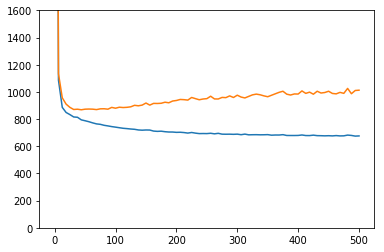

In [5]:
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0, 500, (len(ll_train_set)))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.ylim(0, 1600)
plt.show()

We can get the output of train data/test data by `get_latent()`

In [6]:
latent, _, label = trainer.train_set.get_latent()
train = trainer.train_set
test = trainer.test_set
np.shape(train.indices), np.shape(test.indices)

((1978,), (660,))

## Computing the neighborhood graph with louvain 

Some basic configuration

In [7]:
n_neighbors = 25
train_latent, _, _ = trainer.train_set.get_latent()
test_latent, _, _ = trainer.test_set.get_latent()

There we find connectivity with Guassian similarity.

In [8]:
def find_connective_of_data(latent):
    from sklearn.metrics import pairwise_distances

    D = pairwise_distances(latent)
    sample_range = np.arange(D.shape[0])[:, None]
    indices = np.argpartition(D, n_neighbors-1, axis=1)[:, :n_neighbors]
    indices = indices[sample_range, np.argsort(D[sample_range, indices])]
    distances = D[sample_range, indices]

    target = np.log2(n_neighbors) 
    rhos = np.zeros(distances.shape[0])
    sigmas = np.zeros(distances.shape[0])

    for i in range(distances.shape[0]):
        lo = 0.0
        hi = np.infty
        mid = 1.0
        ith_distances = distances[i]
        non_zero_dists = ith_distances[ith_distances > 0.0]
        rhos[i] = non_zero_dists[0]

        for _ in range(64):
            psum = 0.0
            for j in range(1, distances.shape[1]):
                dist = max(0, (distances[i, j] - rhos[i]))
                psum += np.exp(-(dist / mid))
                val = psum

            if np.fabs(val - target) < 1e-5:
                break

            if val > target:
                hi = mid
                mid = (lo + hi) / 2.0
            else:
                lo = mid
            if hi == np.infty:
                mid *= 2
            else:
                mid = (lo + hi) / 2.0
        sigmas[i] = mid
    sims = np.zeros((latent.shape[0], latent.shape[0]), dtype=np.float64)

    for i in range(indices.shape[0]):
        for j in range(indices.shape[1]):
            sims[i, indices[i, j]] =  np.exp(-((distances[i, j] - rhos[i]) / sigmas[i]))
    connectivities = sims + sims.transpose() - np.multiply(sims, sims.transpose())
    return connectivities

Cluster data with louvain.

In [9]:
connectivities = find_connective_of_data(latent=train_latent)

import louvain
import igraph as ig
s, t = connectivities.nonzero()
weights = connectivities[s, t]
g = ig.Graph(directed=None)
g.add_vertices(connectivities.shape[0])
g.add_edges(list(zip(s, t)))
g.es['weight'] = weights
louvain.set_rng_seed(0)
part = louvain.find_partition(g, louvain.RBConfigurationVertexPartition)
colors = ["red", "blue", 'green', 'yellow', 'silver', 'pink', 'deepskyblue', 'darkcyan','chocolate', 'salmon']
train_membership = part.membership

/home/kardel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


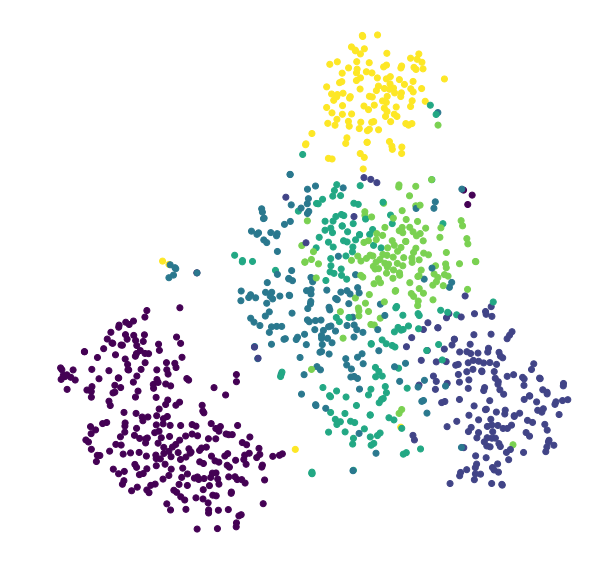

In [10]:
coord, train_indices = Posterior.apply_t_sne(train_latent)
train_membership = np.array(train_membership)
plt.figure(figsize=(10, 10))

plt.scatter(x=coord[:, 0], y=coord[:, 1], c=train_membership[train_indices])
plt.axis("off")
plt.show()
# membership = np.concatenate((test_membership, train_membership))

There we can use some other algorithms like K-means and KNN.

In [11]:
# latent = test_latent
# print(latent)
connectivities = find_connective_of_data(latent=test_latent)

import louvain
import igraph as ig
s, t = connectivities.nonzero()
weights = connectivities[s, t]
g = ig.Graph(directed=None)
g.add_vertices(connectivities.shape[0])
g.add_edges(list(zip(s, t)))
g.es['weight'] = weights
louvain.set_rng_seed(0)
part = louvain.find_partition(g, louvain.RBConfigurationVertexPartition)
colors = ["red", "blue", 'green', 'yellow', 'silver', 'pink', 'deepskyblue', 'darkcyan','chocolate', 'salmon']
test_membership = part.membership

/home/kardel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Use umap for visualization. PCA and autoencoder are also good alternatives.

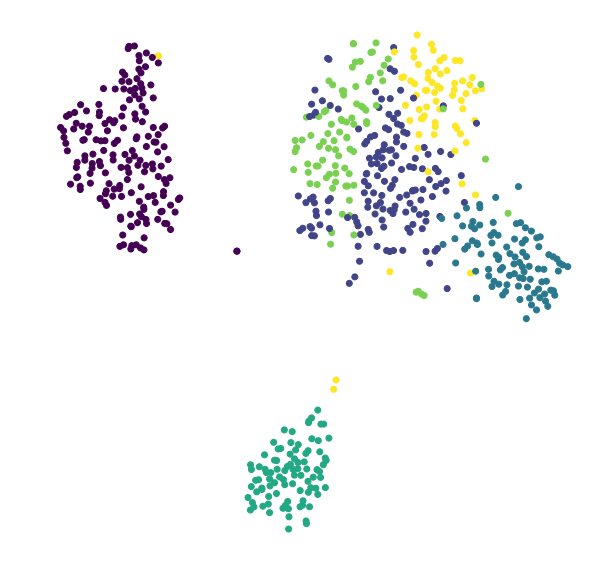

In [12]:
coord, test_indices = Posterior.apply_t_sne(test_latent)
test_membership = np.array(test_membership)
plt.figure(figsize=(10, 10))

plt.scatter(x=coord[:, 0], y=coord[:, 1], c=test_membership[test_indices])
plt.axis("off")
plt.show()

## Cluster with K-means

We can cluster dataset with K means

In [13]:
from sklearn.cluster import KMeans
# print(train_latent)
train_kmeans = KMeans(n_clusters=8).fit(train_latent)
train_kls = train_kmeans.labels_

visualize it with t-SNE

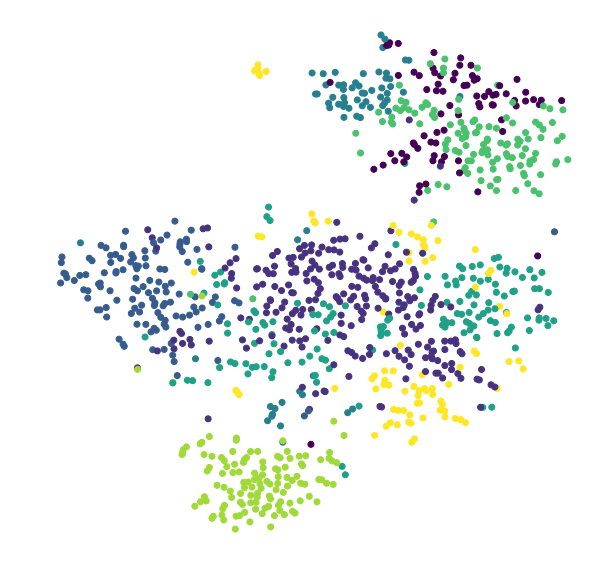

In [14]:
coord, train_indices = Posterior.apply_t_sne(train_latent)
train_kls = np.array(train_kls)
plt.figure(figsize=(10, 10))

plt.scatter(x=coord[:, 0], y=coord[:, 1], c=train_kls[train_indices])
plt.axis("off")
plt.show()


Cluster test dataset and visualize it

In [15]:
from sklearn.cluster import KMeans
test_kmeans = KMeans(n_clusters=8).fit(test_latent)
test_kls = test_kmeans.labels_

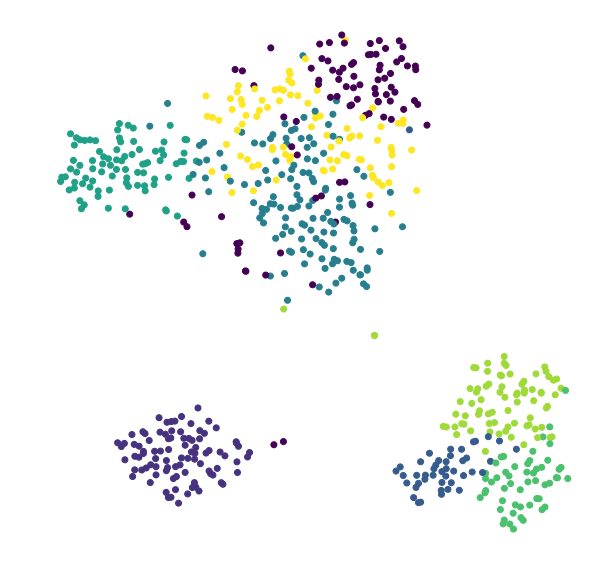

In [16]:
coord, test_indices = Posterior.apply_t_sne(test_latent)
test_kls = np.array(test_kls)
plt.figure(figsize=(10, 10))

plt.scatter(x=coord[:, 0], y=coord[:, 1], c=test_kls[test_indices])
plt.axis("off")
plt.show()


In [40]:
labels = np.zeros(np.shape(gene_dataset.X)[0], dtype=np.int32)
np.shape(labels)
for i, label_i in enumerate(train.indices):
    labels[label_i] = train_kls[i]
for i, label_i in enumerate(test.indices):
    labels[label_i] = test_kls[i]

label the dataset with clusters

In [18]:
gene_dataset2 = Pbmc3kDataset(labels=labels, save_path=save_path)

File data/filtered_gene_bc_matrices.tar.gz already downloaded
Pbmc3K Dataset preprocess
Extracting tar file and read data
end reading data
start preprocessing it


In [41]:
gene_dataset2.labels

array([[3],
       [1],
       [1],
       ...,
       [1],
       [2],
       [1]])

To Romain: I wonder whether it is the model that goes wrong? I think all my operations are right. But if it is, these data points should be clustered well.

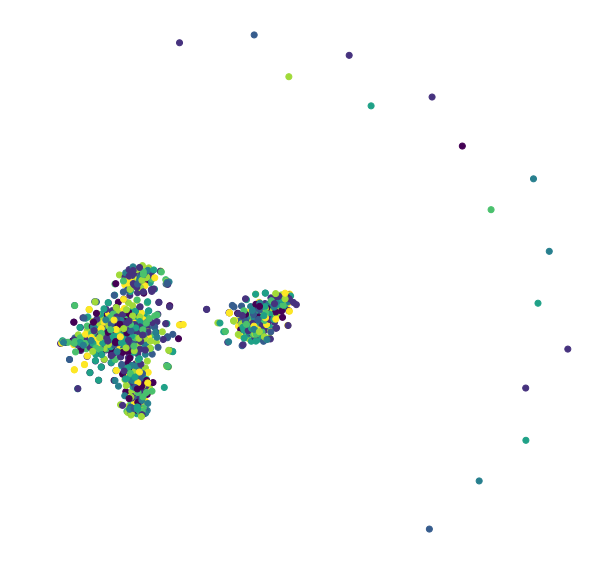

In [20]:
coord, indices = Posterior.apply_t_sne(gene_dataset.X)
plt.figure(figsize=(10, 10))
plt.scatter(x=coord[:, 0], y=coord[:, 1], c=labels[indices])
plt.axis("off")
plt.show()


In [21]:
vae2 = VAE(gene_dataset2.nb_genes, n_batch=gene_dataset2.n_batches * use_batches)
trainer2 = UnsupervisedTrainer(vae2,
                              gene_dataset2,
                              train_size=0.75,
                              use_cuda=use_cuda,
                              frequency=5)
trainer2.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 400/400 [14:42<00:00,  2.21s/it]


In [22]:
train_latent, _, train_label = trainer2.train_set.get_latent()
test_latent, _, test_label = trainer2.test_set.get_latent()

In [30]:
train_asw_score, train_nmi_score, train_ari_score, train_uca_score = trainer2.train_set.clustering_scores()
test_asw_score, test_nmi_score, test_ari_score, test_uca_score = trainer2.test_set.clustering_scores()
df_dict_ = {}
df_dict_["asw"] = [train_asw_score, test_asw_score]
df_dict_["nmi"] = [train_nmi_score, test_nmi_score]
df_dict_["ari"] = [train_ari_score, test_ari_score]
df_dict_["uca"] = [train_uca_score, test_uca_score]

pd.DataFrame(df_dict_)

/home/kardel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Clustering Scores:
Silhouette: -0.0214
NMI: 0.0052
ARI: -0.0003
UCA: 0.1572
Clustering Scores:
Silhouette: -0.0370
NMI: 0.0219
ARI: 0.0020
UCA: 0.1727


,asw,nmi,ari,uca
0,-0.021375,0.005157,-0.000333,0.157230
1,-0.037010,0.021920,0.002031,0.172727


## Find marker genes

scVI provides differential expression table between cells and genes, where we can observe marker genes.

In [31]:
gene_names, expression = trainer2.train_set.differential_expression_table()

In [36]:
print(np.shape(expression))

(80, 8)


Find the highest expression gene. We'd like to find top 20 high expression genes. 

In [32]:
highest_expression_gene_indices = np.argsort(np.sum(expression, axis=1))[:20]
highest_expression_gene = gene_dataset.gene_names[np.argsort(np.sum(expression, axis=1))]
highest_expression_gene

array(['TNFRSF1B', 'SCP2', 'SPEN', 'DRAXIN', 'ERI3', 'MARCKSL1', 'CAPZB',
       'RRAGC', 'ZCCHC11', 'SPATA6', 'MDS2', 'PRDM2', 'PRDX1', 'CAMK2N1',
       'EVA1B', 'ACADM', 'SDHB', 'TMEM50A', 'TMEM234', 'SSBP3', 'ST3GAL3',
       'C1QC', 'CDA', 'LDLRAP1', 'ACOT11', 'ATPAF1', 'SMAP2', 'C1ORF86',
       'ZFP69', 'DDI2', 'PUM1', 'TNFRSF4', 'HMGCL', 'SMIM12', 'DMAP1',
       'PGM1', 'USP33', 'FAAH', 'HDAC1', 'EFHD2', 'TNFRSF9', 'TAL1',
       'SPOCD1', 'C1QA', 'IFI44', 'PPT1', 'PPIE', 'EFCAB14', 'CITED4',
       'RER1', 'AGO4', 'RP11-70P17.1', 'PDZK1IP1', 'SRM', 'CPSF3L',
       'C1QB', 'ATAD3C', 'LRRIQ3', 'C1ORF50', 'ATG4C', 'YTHDF2', 'HSPB11',
       'EBNA1BP2', 'PITHD1', 'TMEM222', 'TRIT1', 'PHACTR4', 'SNHG12',
       'UBIAD1', 'PPP1R8', 'PDIK1L', 'PTAFR', 'PARS2', 'TAF12',
       'TNFRSF25', 'ZNF436', 'STMN1', 'CTNNBIP1', 'TRAPPC3', 'ZNF593'],
      dtype='<U18')

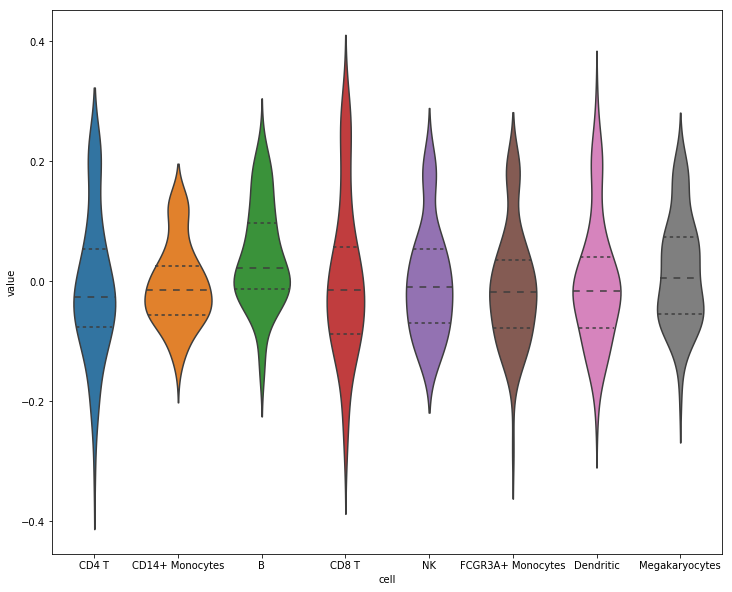

In [37]:
import seaborn as sns
df_dict = {}
df_dict['cell'] = []
df_dict['gene'] = []
df_dict['value'] = []
for i_gene in range(np.shape(expression)[0]):
    for i_cell in range(np.shape(expression)[1]):
        df_dict['cell'].append(gene_dataset2.cell_types[i_cell])
        df_dict['gene'].append(gene_names[i_gene])
        df_dict['value'].append(expression[i_gene, i_cell])
df = pd.DataFrame(df_dict)
fig, ax = plt.subplots(figsize=(12, 10))
sns.violinplot(x='cell', y='value', data=df, inner="quart",split=True)
plt.show()

Use dot plot to show the expression.

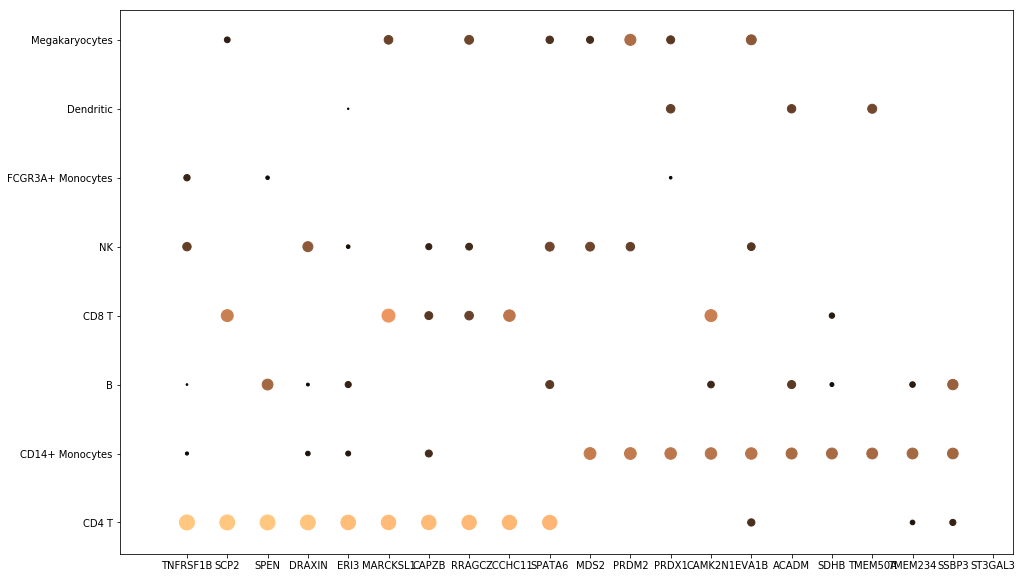

In [39]:
fig, ax = plt.subplots(figsize=(16, 10))
size = []
x = []
y = []
plt.xticks(np.arange(len(highest_expression_gene)), highest_expression_gene)
plt.yticks(np.arange(len(gene_dataset2.cell_types)), gene_dataset2.cell_types)
for index, gene in enumerate(highest_expression_gene_indices):
    for cell_index in range(len(gene_dataset2.cell_types)):
        size.append(expression[index, cell_index])
        x.append(index)
        y.append(cell_index)

size = np.array(size)
c = np.maximum(size, 0)* 255
size = np.maximum(size, 0) * 1000

plt.scatter(x=x, y=y, s=size, c=c, cmap='copper')

To Romain:
    1. Pbmc3k doesn't have any labels. So I cannot calculate clustering scores.
    2. I think we can compare these two clustering methods.
    3. The figure in In[20] is weird. Technically, it should be well-clustered.
    